## Kaggle Titanic Competition
Determining survivers based on some data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statistics import mean
from collections import Counter

# Hiding stupid warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Loading data
titanic = pd.read_csv('Data/train.csv')

In [3]:
# Preprocessing data
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score

### Taking a look at the data
Text based data needs to be turned into numerical data for the algorithm to understand.

**Text-based Columns:** Name, Sex, Ticket, Cabin, Embarked

**Numerical Columns:** PassengerId, Survived, Pclass, Age, SibSp, Parch, Fare

In [4]:
# Printing first 10 rows of dataset:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


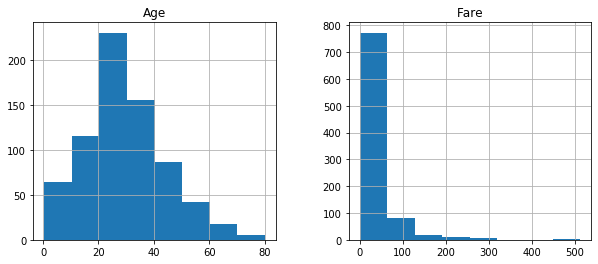

In [5]:
# Plotting histograms for some interesting numerical columns:
plot = titanic[['Age', 'Fare']].hist(bins=8, figsize=(10,4))

### Defining some general functions & transformers

In [6]:
# Function to merge numerical columns
def mergeColumns(frame, columns, new):
    frame[new] = frame[columns].sum(axis=1)
    frame.drop(columns, axis=1, inplace=True)
    return frame

In [7]:
# Function to get dataframe indices of selected columns to access them in array form
def getFrameIndices(frame, columns):
    return [frame.columns.get_loc(col) for col in columns]

def getArrayIndices(category, columns):
    return [list(category).index(col) for col in columns]

In [8]:
# Custom transformer to handle dataframes directly in pipeline
class FrameHandler(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns
        
    def fit(self, X):
        return self
    
    def transform(self, X):
        if self.columns is None:
            return X.values
        return X[self.columns].values

In [9]:
# Custom OneHotEncoder that allows for specific columns to be encoded only
class OneHotColumn(BaseEstimator, TransformerMixin):
    def __init__(self, category, columns):
        self.category = category
        self.columns = columns
        
        self.index = getArrayIndices(self.category, self.columns)
        self.encoder = OneHotEncoder()
    
    def fit(self, X):
        return self
    
    def transform(self, X):
        for column in range(len(self.columns)):
            encodedCol = OneHotEncoder(sparse=False).fit_transform(np.array(X[:, self.index[column]]).reshape(-1,1))
            X = np.delete(X, self.index[column], axis=1)
            X = np.concatenate((X, encodedCol), axis=1)
        return X

In [10]:
# Loading data
titanic = pd.read_csv('Data/train.csv')

# Defining label array
labels = np.array(titanic['Survived'])

# Feature engineering / reduction
titanic.drop(['PassengerId', 'Name', 'Ticket', 'Cabin', 'Survived'], axis=1, inplace=True)

titanic = mergeColumns(titanic, ['SibSp', 'Parch'], 'Relations')
titanic['Embarked'].fillna(Counter(titanic['Embarked']).most_common(1)[0][0], inplace=True)

# Splitting train and test data
Xtrain, Xtest, labelsTrain, labelsTest = train_test_split(titanic, labels, test_size=0.2)

# Defining data categories
numerical = titanic.select_dtypes(include=[np.number]).columns.values
categorical = titanic.select_dtypes(exclude=[np.number]).columns.values

numerical, categorical

(array(['Pclass', 'Age', 'Fare', 'Relations'], dtype=object),
 array(['Sex', 'Embarked'], dtype=object))

### Dealing with numerical data
* Getting rid of unnecessary columns
    * Wanted columns: **Pclass, Age, SibSp, Parch, Fare**
* Using a pipeline to process and properly encode numerical columns with pre-made and custom SciKit Learn transformers. 
    * **Pclass:** OneHot-Encoding
    * **Fare:** Binning
    * **SibSp & Parch:** Summing up features, binarizing and OneHot-Encoding 

In [11]:
# Custom transformer for binning
class BinningColumn(BaseEstimator, TransformerMixin):
    def __init__(self, category, column, steps, bound):
        self.category = category
        self.column = column
        self.steps = steps
        self.bound = bound

        self.index = getArrayIndices(self.category, [self.column])
        self.intervalls = np.linspace(0, self.bound, self.steps + 1)
        
    def fit(self, X):
        return self
    
    def transform(self, X):
        binCol = [float(self.intervalls[-1]) if n >= float(self.bound) else n for n in X[:, self.index[0]]]
        binCol = [float(self.intervalls[1] - 1) if n == 0.0 else n for n in binCol]
        X[:, self.index[0]] = pd.cut(binCol, bins=self.intervalls, labels=self.intervalls[1:])
        return X

In [12]:
numPipe = Pipeline([
    ('frameHandler', FrameHandler(columns=numerical)),
    ('imputer', SimpleImputer(strategy='median')),
    ('binningFare', BinningColumn(category=numerical, column='Fare', steps=5, bound=50)),
    ('binningAge', BinningColumn(category=numerical, column='Age', steps=12, bound=60)),
    ('encode', OneHotColumn(category=numerical, columns=['Pclass'])),
    ('scaler', StandardScaler()),
])

### Dealing with categorical data
* Getting rid of unnecessary columns
    * Wanted columns: **Sex, Cabin, Embarked**
* Using a pipeline to process and properly encode rest of the data for training using pre-made and custom SciKit Learn transformers. 

In [13]:
catPipe = Pipeline([
    ('frameHandler', FrameHandler(columns=categorical)),
    ('encode', OneHotColumn(category=categorical, columns=['Embarked', 'Sex'])),
])

### Putting numerical and categorical data back together

In [14]:
titanPipe = FeatureUnion(transformer_list=[
    ('numPipe', numPipe),
    ('catPipe', catPipe),
])

processedTrain = titanPipe.fit_transform(Xtrain)
processedTest = titanPipe.transform(Xtest)

In [15]:
processedTrain[1:10]

array([[-0.5157789291553717, -0.9857320251014343, -0.549274044099617,
        -0.5492224851628044, -0.5253433763572547, 0.900946632495845, 0.0,
        0.0, 1.0, 0.0, 1.0],
       [-0.10683171583841776, -0.9857320251014343, -0.549274044099617,
        -0.5492224851628044, -0.5253433763572547, 0.900946632495845, 0.0,
        1.0, 0.0, 0.0, 1.0],
       [-0.10683171583841776, -0.9857320251014343, -0.549274044099617,
        -0.5492224851628044, -0.5253433763572547, 0.900946632495845, 0.0,
        0.0, 1.0, 0.0, 1.0],
       [-0.10683171583841776, -0.33041811112176933, -0.549274044099617,
        -0.5492224851628044, 1.9035169091386241, -1.1099436569619658,
        0.0, 0.0, 1.0, 1.0, 0.0],
       [1.5289571374293978, 1.6355236308172256, 0.6633867912458941,
        1.8207557538427515, -0.5253433763572547, -1.1099436569619658,
        1.0, 0.0, 0.0, 0.0, 1.0],
       [-0.5157789291553717, 1.6355236308172256, -0.549274044099617,
        1.8207557538427515, -0.5253433763572547, -1.1099436569

### Training & Testing Classifier

In [16]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import RandomizedSearchCV

In [17]:
clf = DecisionTreeClassifier()

paramRanges = {
    'max_depth': [1,20],
    'min_samples_split': [0.1, 10],
    'min_samples_leaf': [1, 5],
    'max_features': [1, 4]
}

classifierSearch = RandomizedSearchCV(clf, param_distributions=paramRanges, cv=5)

classifierSearch.fit(processedTrain, labelsTrain)
bestClf = classifierSearch.best_estimator_

predictions = bestClf.predict(processedTest)

/Users/dan/Software/miniconda/envs/ml/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


### Calculating Precision & Recall

In [18]:
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import roc_auc_score

precision = precision_score(labelsTest, predictions)
recall = recall_score(labelsTest, predictions)
accuracy = bestClf.score(processedTest, labelsTest)
roc = roc_auc_score(labelsTest, predictions)

precision, recall, accuracy, roc

(0.7884615384615384,
 0.6029411764705882,
 0.7877094972067039,
 0.7519210386857446)

In [19]:
relevance = classifierSearch.best_estimator_.feature_importances_

In [20]:
catAts = catPipe.named_steps['encode']
numAts = numPipe.named_steps['encode']

ats = list(numAts.category) + list(catAts.category)

In [21]:
sorted(zip(relevance, ats), reverse=True)

[(0.13408013660391513, 'Pclass'),
 (0.11694020035862716, 'Embarked'),
 (0.10230547729741579, 'Age'),
 (0.062014757421314, 'Fare'),
 (0.017207354892023796, 'Relations'),
 (0.0, 'Sex')]